In [45]:
import math
import os
import subprocess
import time
import scipy
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import itertools
import pickle
from tabulate import tabulate
from skopt import gp_minimize
from g4beam import *
from tqdm import *

In [20]:
t_emit = 0.110  # mm
momentum = 100  # MeV/c
beta = 0.03    # m
alpha = 1.0     # dimensionless
l_emit = 1      # mm
pz_std = 0.8    # MeV/c
vd_dist = 24    # mm

pre_w1 = gen_distribution((beta, alpha, t_emit, 0, 0), (beta, alpha, t_emit, 0, 0), momentum, pz_std, z_emit=l_emit, N=20000)
pre_w1["PDGid"] = -13
print(pre_w1)
print_all_params(pre_w1)

              x         y  z         Px         Py          Pz         t  \
0      2.059019 -1.353136  0  -5.609073  11.204319   99.766243  0.250446   
1      1.480105 -1.515424  0  -3.872492   2.634431  100.223135  1.081913   
2      1.447914 -1.389733  0   1.143408  -4.545584  100.798296  1.059049   
3     -3.580900  0.144573  0  11.172566  -4.734292   97.435028  0.928092   
4     -2.756349 -1.359626  0   8.150456   1.523554   98.556194  1.164258   
...         ...       ... ..        ...        ...         ...       ...   
19995 -2.620136  0.202013  0  14.178043   2.111304   98.985733  0.127419   
19996 -0.951581 -3.471207  0  -3.081516   6.662543   99.193528  0.976031   
19997 -2.630646 -0.986450  0   0.472232   3.760799   98.592907 -2.036364   
19998  0.503704  1.817262  0   5.585862   1.218610   98.559242 -0.263857   
19999 -0.101826  1.767486  0   0.740629  -1.316104   99.512020 -0.939393   

       PDGid  EventID  TrackID  ...  ProperTime  PathLength PolX PolY PolZ  \
0        

In [41]:

results = []
def callback(res):
    x = res.x
    y = f(x)
    results.append((x, y))
    
def f(x):
    params = {
        't_emit': 0.145, # mm
        'momentum': 100, # MeV/c
        'beta': 0.03, # m
        'alpha': 1, # dimensionless
        'l_emit': 1, # mm
        'pz_std': 1, # MeV/c
        'vd_dist': 24, # mm
        'w1_length': 9.207510617,
        'w1_angle': 49.78231334,
        'w2_length': 6.724887901827298,
        'w2_angle': 42.245718529695516,
        'drift_length': 16000,
        'rf_freq': 0.025,
        'rf_phase': x[0],
        'rf_length': x[1],
        'rf_grad': x[2]
    }
    return run(params)

def run(params):
    # Run best case
    pre_w1 = gen_distribution(
        (params["beta"], params["alpha"], params["t_emit"], 0, 0),
        (params["beta"], params["alpha"], params["t_emit"], 0, 0),
        params["momentum"],
        params["pz_std"],
        z_emit=params["l_emit"],
        N=50000)
    pre_w1["PDGid"] = -13
    print("Running first wedge")
    post_w1 = run_distribution(
        pre_w1,
        params["w1_length"],
        params["w1_angle"],
        params["vd_dist"],
        axis=0)
    # post_correct = post_w1
    post_correct = remove_dispersion(post_w1)
    reverse_transverse = post_correct.copy(deep=True)
    reverse_transverse["Px"] *= -1
    reverse_transverse["Py"] *= -1
    drift_to_start = params["drift_length"]-params["rf_length"]/2
    post_drift = recenter_t(z_prop(post_correct, drift_to_start))
    no_transverse = remove_transverse(post_drift)
    print("Running RF cavity")
    post_cavity = cut_pz(recenter_t(run_g4beam(no_transverse, "G4_RFCavity.g4bl", RF_length=params["rf_length"], frfcool=params["rf_freq"], ficool=params["rf_phase"], Vrfcool=params["rf_grad"], nparticles=len(no_transverse))), tails=0.15)
    pre_w2 = recombine_transverse(post_cavity, reverse_transverse)
    return np.std(p_total(cut_pz(pre_w2)))

    
    print("Running second wedge")
    """
    post_w2 = run_distribution(
        pre_w2,
        params["w2_length"],
        params["w2_angle"],
        params["vd_dist"],
        axis=1
    )
    post_w2_cut = recenter_t(cut_outliers(post_w2))
    #print_all_params(post_w2_cut)
    

    # get distributions
    # emits = {}
    # SAMPLE_DISTS = [pre_w1, post_correct, pre_w2, post_w2, post_w2_cut]
    # SAMPLE_TITLES = ["Initial distribution", "After first wedge", "After RF cavity + 15% cut", "After second wedge", "After 4 sigma cut"]
    # for sample, dist in zip(SAMPLE_TITLES, SAMPLE_DISTS):
    #     x_emit, y_emit, z_emit = emittances(cut_outliers(run_distribution(dist, params["w1_length"], params["w1_angle"], params["vd_dist"], axis=0)))
    #     print(f"{sample}: ", x_emit, y_emit, z_emit)
    #     emits[sample] = [x_emit, y_emit, z_emit]
    # return emits

    return emittances(cut_outliers(run_distribution(post_w2, params["w2_length"], params["w2_angle"], params["vd_dist"], axis=0)))
    """

if __name__ == "__main__":
    # list of parameters to optimize
    params = {
        't_emit': 0.145, # mm
        'momentum': 100, # MeV/c
        'beta': 0.03, # m
        'alpha': 1, # dimensionless
        'l_emit': 1, # mm
        'pz_std': 1, # MeV/c
        'vd_dist': 24, # mm
        'w1_length': 9.20751061747799,
        'w1_angle': 49.78231333988419,
        'w2_length': 6.724887901827298,
        'w2_angle': 42.245718529695516,
        'drift_length': 16000,
        'rf_freq': 0.025,
        'rf_phase': 0.001987066319906211,
        'rf_length': 5153.756925848655,
        'rf_grad': 4.046563465382562
    }
    
    
    # example of full run through
    # start = time.time()
    # emits = run(params)
    # print(f"Time elapsed: {time.time() - start:.1f}")
    # print(emits)
    np.int = int
    res = gp_minimize(f,                  # the function to minimize
                      [
                        (float(-90), float(90)), (float(2000), float(6000)), (float(1), float(10))          # bounds on 1st wedge length
                                  # bounds on 1st wedge angle
                      ],
                      x0=[float(0), float(4700), float(7)],       # starting values
                      acq_func="EI",      # the acquisition function
                      n_calls=20,
                      initial_point_generator = "random",         # the number of evaluations of f
                      n_initial_points=15,  # the number of random initialization points
                      # noise=0.1**2,       # the noise level (optional)
                      random_state=1234,
                      callback=[callback])   # the random seed
    


Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running first wedge
Running RF cavity
Running firs

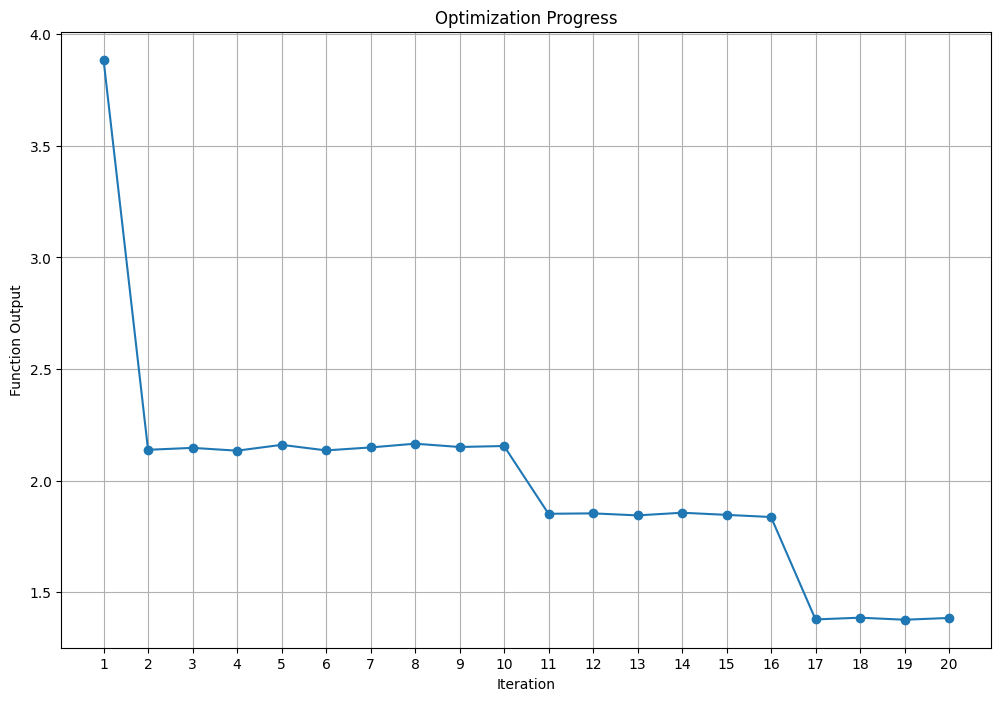

In [49]:
x_values, y_values = zip(*results)

# You might want to process x_values if they are multidimensional
# For example, you could plot one parameter at a time or some function of the parameters

# Plotting
iterations = list(range(1, len(y_values) + 1))  # Starting from 1 to the number of iterations

plt.figure(figsize=(12, 8))
plt.plot(iterations, y_values, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Function Output')
plt.title('Optimization Progress')
plt.xticks(iterations) 
plt.grid(True)
plt.show()


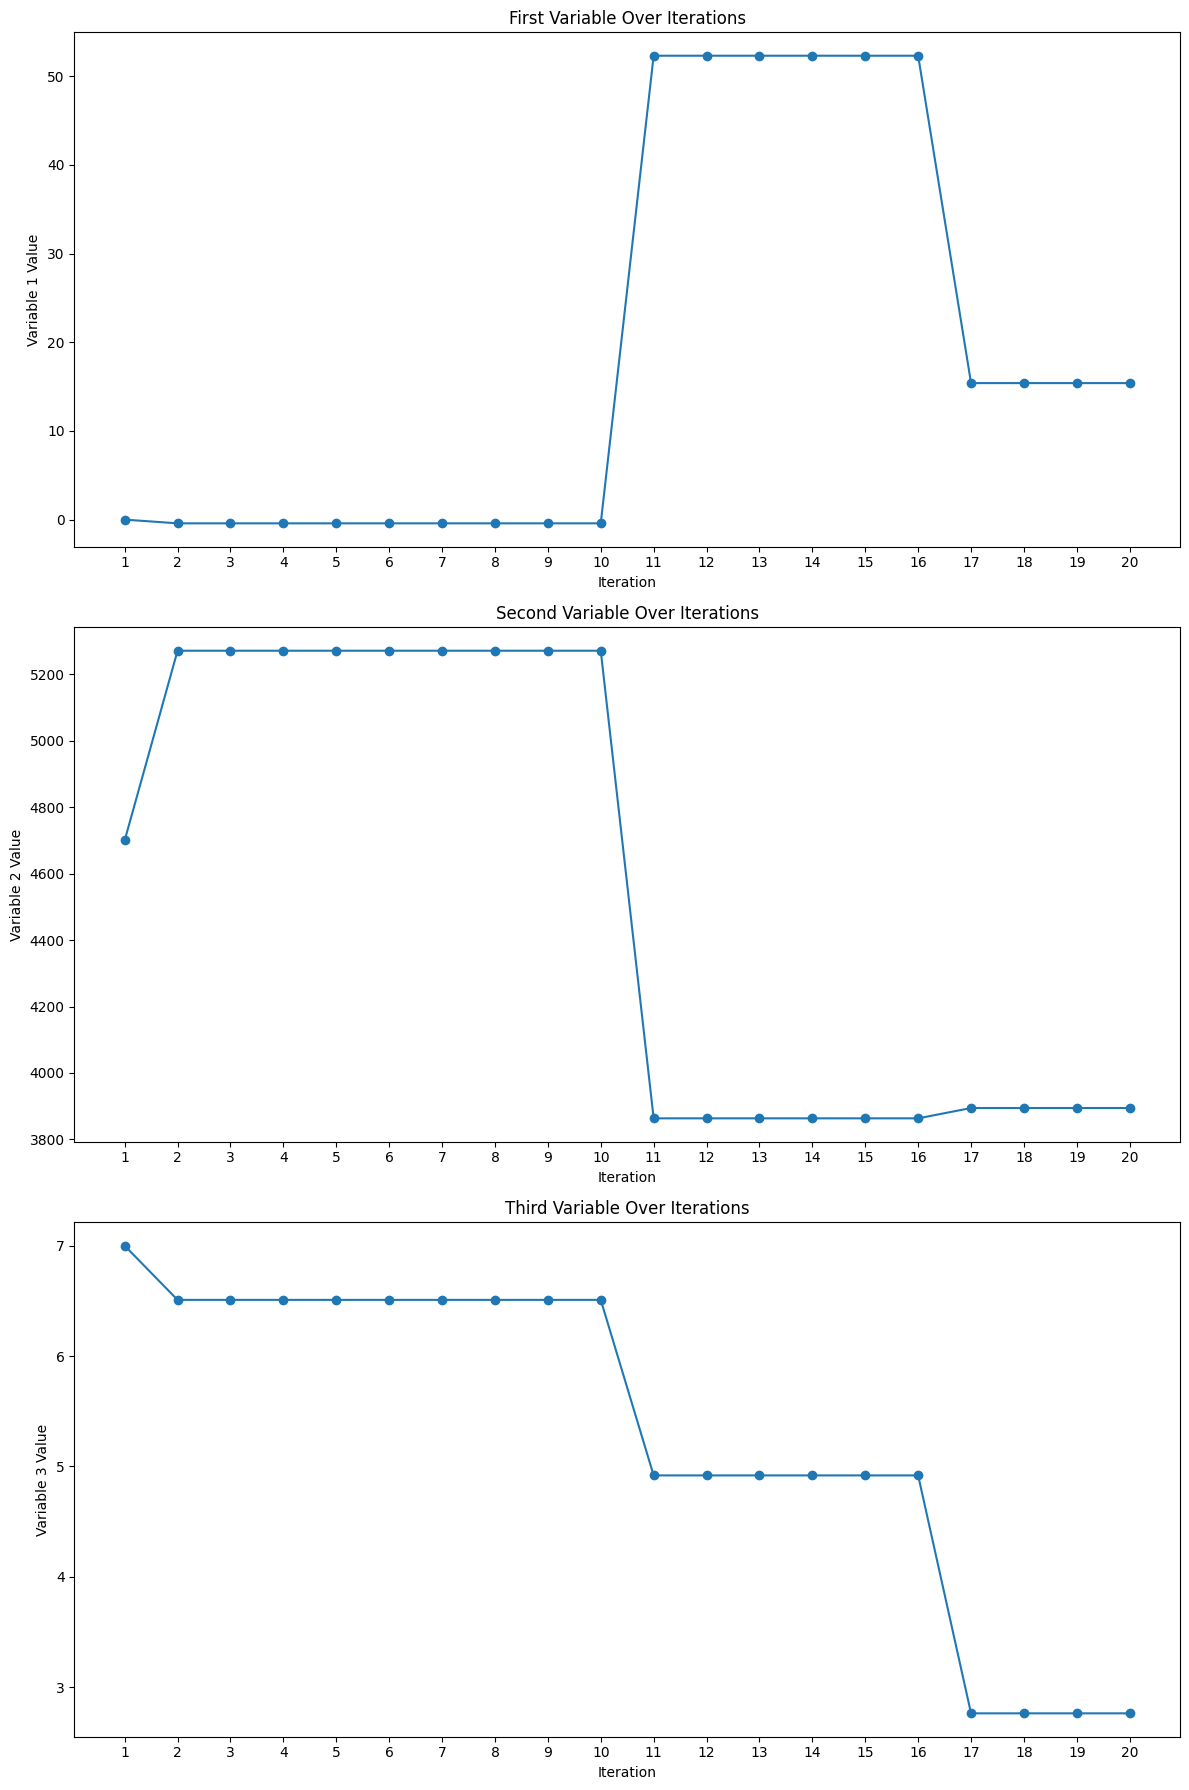

In [51]:
fig, axs = plt.subplots(3, 1, figsize=(12, 18))  # Adjust the figure size as needed

iterations = list(range(1, len(x_values) + 1))

x1_values, x2_values, x3_values = zip(*x_values)

# First variable plot
axs[0].plot(iterations, x1_values, marker='o', linestyle='-')
axs[0].set_title('First Variable Over Iterations')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Variable 1 Value')
axs[0].set_xticks(iterations)  # Set x-axis ticks

# Second variable plot
axs[1].plot(iterations, x2_values, marker='o', linestyle='-')
axs[1].set_title('Second Variable Over Iterations')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Variable 2 Value')
axs[1].set_xticks(iterations)  # Set x-axis ticks

# Third variable plot
axs[2].plot(iterations, x3_values, marker='o', linestyle='-')
axs[2].set_title('Third Variable Over Iterations')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Variable 3 Value')
axs[2].set_xticks(iterations)  # Set x-axis ticks

plt.tight_layout()
plt.show()

In [44]:
print(res.x[0])
print(res.x[1])
print(res.x[2])
print(res.fun)
results_wedge1 = {"x[0]": 2.786015484404336, "x[1]": 32.23973795863484, "fun": 0.06972472316264307}

15.394018345892377
3894.4205365640782
2.7613152717607488
1.383470776931725


In [25]:
def func(x):
    length, angle = x
    return emittances(cut_outliers(run_distribution(pre_w1, length, angle, vd_dist, axis=0)))[0]

start = time.time()
print("optim result")
optim_result = minimize(func, [7.5, 45], method="Nelder-Mead", bounds=((1, 10), (30, 70)), options=dict(fatol=1e-6))

# Get results
w1_length, w1_angle = optim_result.x
print(f"Length = {w1_length:.2f} mm\nAngle = {w1_angle:.1f} deg")
print("Time spent:", time.time()-start)

# Runs a single case with the optimal parameters
post_w1 = run_distribution(pre_w1, w1_length, w1_angle, vd_dist, axis=0)
print("without cutting outliers")
print_all_params(post_w1)
print("with cutting outliers")
print_all_params(cut_outliers(post_w1))

optim result
iter value
  35 3.11465e-02
Length = 6.31 mm
Angle = 50.8 deg
Time spent: 1112.05450963974
without cutting outliers
-----------------------------
Twiss parameters for X
emit  = 0.033185554052354085 mm
beta  = 0.04474899453697362 m
gamma = 257.4990608519201 1/m
alpha = -3.243890267462574
D     = 0.016633030167832664 m
D'    = -0.18096093932730517

Twiss parameters for Y
emit  = 0.11453152665323604 mm
beta  = 0.022631466376376124 m
gamma = 76.33581311801115 1/m
alpha = -0.8529896763112677
D     = 0.00014466208575203296 m
D'    = 0.008271876756515466

Z-emittance:  6.936031294548839 mm
Z std: 180.51427826382562 mm
p std: 6.054792162225793 MeV/c
Mean momentum: 89.46358918467075 MeV/c
-----------------------------
with cutting outliers
-----------------------------
Twiss parameters for X
emit  = 0.03114653359295874 mm
beta  = 0.046211072053618026 m
gamma = 266.5281881300157 1/m
alpha = -3.3640085175273287
D     = 0.016697610605212732 m
D'    = -0.2004381564262464

Twiss paramet

In [8]:
post_correct = remove_dispersion(post_w1)

# Ignore transverse momentums
no_transverse = remove_transverse(post_correct)

# Reverse transverse momentums in saved copy
reverse_transverse = post_correct.copy(deep=True)
reverse_transverse["Px"] *= -1
reverse_transverse["Py"] *= -1

In [ ]:
drift_length = 16000
rf_freq = 0.025

start = time.time()
# Function to optimize

def func(x):
    rf_phase, rf_length, rf_grad = x
    drift_to_start = drift_length-rf_length/2
    post_drift = recenter_t(z_prop(no_transverse, drift_to_start))
    post_cavity = run_g4beam(post_drift, "G4_RFCavity.g4bl", RF_length=rf_length, frfcool=rf_freq, ficool=rf_phase, Vrfcool=rf_grad, nparticles=len(no_transverse))
    pre_w2 = recombine_transverse(post_cavity, reverse_transverse)
    return np.std(p_total(cut_pz(pre_w2)))

# Run optimization
optim_result = minimize(func, [0, 4700, 7], method="Nelder-Mead", bounds=((-90, 90), (2000, 6000), (1, 10)), options=dict(fatol=1e-6))


# Get results
###rf_phase, rf_length, rf_grad = optim_result.x
print(f"Phase = {rf_phase:.2f} deg\nLength = {rf_length:.0f} mm\nGradient = {rf_grad:.2f} MV/m\nFrequency = {rf_freq*1000:.1f} MHz")
print("Time spent:", time.time()-start)

# Runs a single case with the optimal parameters and add the transverse back in
drift_to_start = drift_length-rf_length/2
post_drift = recenter_t(z_prop(no_transverse, 1))
print(post_drift)
post_cavity = cut_pz(recenter_t(run_g4beam(post_drift, "G4_RFCavity.g4bl", RF_length=rf_length, frfcool=rf_freq, ficool=rf_phase, Vrfcool=rf_grad)))
pre_w2 = recombine_transverse(post_cavity, reverse_transverse)
print_all_params(pre_w2)

iter value
 184 1.30741e+00
Phase = 0.00 deg
Length = 5603 mm
Gradient = 5.04 MV/m
Frequency = 25.0 MHz
Time spent: 28229.194204092026
              x         y  z  Px  Py       Pz         t  PDGid  EventID  \
0     -1.592662 -1.376717  1   0   0  82.3703  0.887208    -13        1   
1     -0.726708  3.133037  1   0   0  83.9939  0.765993    -13        2   
2      1.537092  2.184289  1   0   0  81.1350 -0.885327    -13        3   
3      2.287320  0.702170  1   0   0  83.0117  0.816284    -13        4   
4      0.575956  0.702842  1   0   0  95.5598  0.535075    -13        5   
...         ...       ... ..  ..  ..      ...       ...    ...      ...   
19995 -1.048716  1.198121  1   0   0  93.0621 -1.077362    -13    19996   
19996  0.191389  1.360253  1   0   0  89.7532 -0.914016    -13    19997   
19997 -0.661561 -0.127066  1   0   0  87.5555  2.266499    -13    19998   
19998 -0.528903  2.057103  1   0   0  83.1165 -1.403756    -13    19999   
19999  2.231400 -2.570029  1   0   0  88

In [39]:
drift_length = 16000
rf_freq = 0.025

start = time.time()
# Function to optimize

"""
def func(x):
    rf_phase, rf_length, rf_grad = x
    drift_to_start = drift_length-rf_length/2
    post_drift = recenter_t(z_prop(no_transverse, drift_to_start))
    post_cavity = run_g4beam(post_drift, "G4_RFCavity.g4bl", RF_length=rf_length, frfcool=rf_freq, ficool=rf_phase, Vrfcool=rf_grad, nparticles=len(no_transverse))
    pre_w2 = recombine_transverse(post_cavity, reverse_transverse)
    return np.std(p_total(cut_pz(pre_w2)))

# Run optimization
optim_result = minimize(func, [0, 4700, 7], method="Nelder-Mead", bounds=((-90, 90), (2000, 6000), (1, 10)), options=dict(fatol=1e-6))
"""
"""
# Get results
###rf_phase, rf_length, rf_grad = optim_result.x
print(f"Phase = {rf_phase:.2f} deg\nLength = {rf_length:.0f} mm\nGradient = {rf_grad:.2f} MV/m\nFrequency = {rf_freq*1000:.1f} MHz")
print("Time spent:", time.time()-start)
"""

# Runs a single case with the optimal parameters and add the transverse back in
drift_to_start = drift_length-res.x[1]/2
post_drift = recenter_t(z_prop(no_transverse, 1))
print(post_drift)
post_cavity_bays = cut_pz(recenter_t(run_g4beam(post_drift, "G4_RFCavity.g4bl", RF_length=res.x[1], frfcool=rf_freq, ficool=res.x[0], Vrfcool=res.x[2])))
pre_w2_bays = recombine_transverse(post_cavity_bays, reverse_transverse)
print_all_params(pre_w2_bays)

              x         y  z  Px  Py       Pz         t  PDGid  EventID  \
0      2.302134  3.451160  1   0   0  74.7956 -0.219357    -13        1   
1      1.058776  0.547252  1   0   0  87.1935  0.311997    -13        2   
2     -1.144385 -1.413497  1   0   0  88.9256  0.819818    -13        3   
3     -2.832079  0.454210  1   0   0  81.3157  0.441757    -13        4   
4      1.830717  3.496317  1   0   0  86.0620  0.612592    -13        5   
...         ...       ... ..  ..  ..      ...       ...    ...      ...   
19995  1.110734  1.837253  1   0   0  94.6046 -1.840125    -13    19996   
19996 -0.700762  2.045689  1   0   0  84.5113 -0.590770    -13    19997   
19997  0.616732  4.518944  1   0   0  77.1291 -0.004644    -13    19998   
19998 -0.754372  1.412571  1   0   0  79.1194  0.681555    -13    19999   
19999  1.287649  2.740360  1   0   0  86.6345  0.068563    -13    20000   

       TrackID  ...  ProperTime  PathLength  PolX  PolY  PolZ     InitX  \
0            1  ...    0

In [ ]:
print(np.std(p_total(cut_pz(pre_w2))))

3.4199453073559796


In [ ]:
PARAMS = [
    "t_emit",
    "momentum",
    "beta",
    "alpha",
    "l_emit",
    "pz_std",
    "vd_dist",
    "w1_length",
    "w1_angle",
    "w2_length",
    "w2_angle",
    "drift_length",
    "rf_freq",
    "rf_phase",
    "rf_length",
    "rf_grad"
]
# Show parameters
{k:globals()[k] for k in PARAMS}

{'t_emit': 0.145,
 'momentum': 100,
 'beta': 0.03,
 'alpha': 0.7,
 'l_emit': 1,
 'pz_std': 1,
 'vd_dist': 24,
 'w1_length': 7.498470237012953,
 'w1_angle': 47.045876731630415,
 'w2_length': 5.987709516854379,
 'w2_angle': 56.828937918078736,
 'drift_length': 16000,
 'rf_freq': 0.025,
 'rf_phase': 0.0005802320670262949,
 'rf_length': 5500.98783997892,
 'rf_grad': 4.829977594880215}

In [ ]:
print(rf_phase)


0.0005802320670262949


In [ ]:
start = time.time()
# Run best case
pre_w1 = gen_distribution((beta, alpha, t_emit, 0, 0), (beta, alpha, t_emit, 0, 0), momentum, pz_std, z_emit=l_emit, N=50000)
pre_w1["PDGid"] = -13
print("Running first wedge")
post_w1 = run_distribution(pre_w1, w1_length, w1_angle, vd_dist, axis=0)
# post_correct = post_w1
post_correct = remove_dispersion(post_w1)
reverse_transverse = post_correct.copy(deep=True)
reverse_transverse["Px"] *= -1
reverse_transverse["Py"] *= -1
drift_to_start = drift_length-rf_length/2
post_drift = recenter_t(z_prop(post_correct, drift_to_start))
no_transverse = remove_transverse(post_drift)
print("Running RF cavity")
post_cavity = cut_pz(recenter_t(run_g4beam(no_transverse, "G4_RFCavity.g4bl", RF_length=rf_length, frfcool=rf_freq, ficool=rf_phase, Vrfcool=rf_grad, nparticles=len(no_transverse))), tails=0.15)
pre_w2 = recombine_transverse(post_cavity, reverse_transverse)
print("Running second wedge")
post_w2 = run_distribution(pre_w2, w2_length, w2_angle, vd_dist, axis=1)
post_w2_cut = recenter_t(cut_outliers(post_w2))
print_all_params(post_w2_cut)
print(f"Time elapsed: {time.time() - start:.1f}")

Running first wedge
Running RF cavity
Running second wedge
-----------------------------
Twiss parameters for X
emit  = 0.0429038511921486 mm
beta  = 0.04535370112419791 m
gamma = 233.7565132109962 1/m
alpha = -3.098664718230441
D     = -7.681383849076922e-06 m
D'    = 0.0004999851163463262

Twiss parameters for Y
emit  = 0.0563477545404728 mm
beta  = 0.033392827397133236 m
gamma = 178.44111798760397 1/m
alpha = -2.2268034160005117
D     = 0.008869825765041714 m
D'    = 0.04858886633234298

Z-emittance:  45.59349361862641 mm
Z std: 676.8512095629462 mm
p std: 12.58218530024431 MeV/c
Mean momentum: 71.85676668016633 MeV/c
-----------------------------
Time elapsed: 166.1


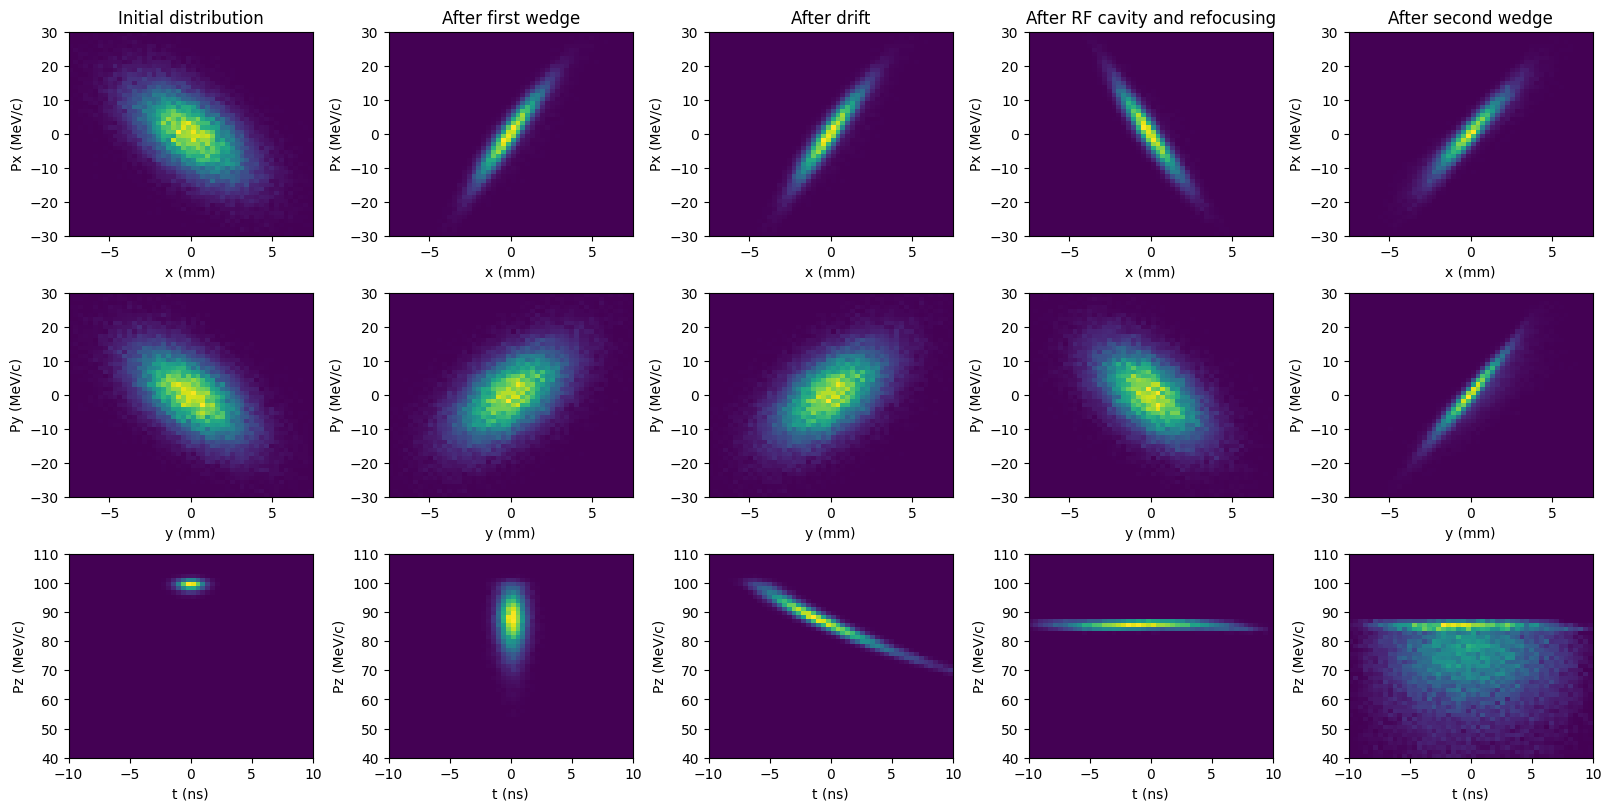

In [ ]:
# Make some phase space plots
PLOT_TARGETS = [pre_w1, post_correct, post_drift, pre_w2, remove_dispersion(post_w2_cut)]
PLOT_TITLES = ["Initial distribution", "After first wedge", "After drift", "After RF cavity and refocusing", "After second wedge"]
PLOT_AXES = [("x", "Px"), ("y", "Py"), ("t", "Pz")]
PLOT_LABELS = [("x (mm)", "Px (MeV/c)"), ("y (mm)", "Py (MeV/c)"), ("t (ns)", "Pz (MeV/c)")]
T_RANGES = [[-7.5, 7.5], [-30, 30]]
L_RANGES = [[-10, 10], [40, 110]]

fig, axes = plt.subplots(nrows = len(PLOT_AXES), ncols = len(PLOT_TARGETS), layout="constrained")
fig.set_size_inches(16, 8)
for i, df in enumerate(PLOT_TARGETS):
    axes[0][i].set_title(PLOT_TITLES[i])
    for j, ((xaxis, yaxis), (xlabel, ylabel)) in enumerate(zip(PLOT_AXES, PLOT_LABELS)):
        ax = axes[j][i]
        ax.hist2d(df[xaxis], df[yaxis], bins=50, range=L_RANGES if j == 2 else T_RANGES)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
# fig.suptitle(f"temit={t_emit*1000:.0f} μm, σP={pz_std:.2f} MeV/c")

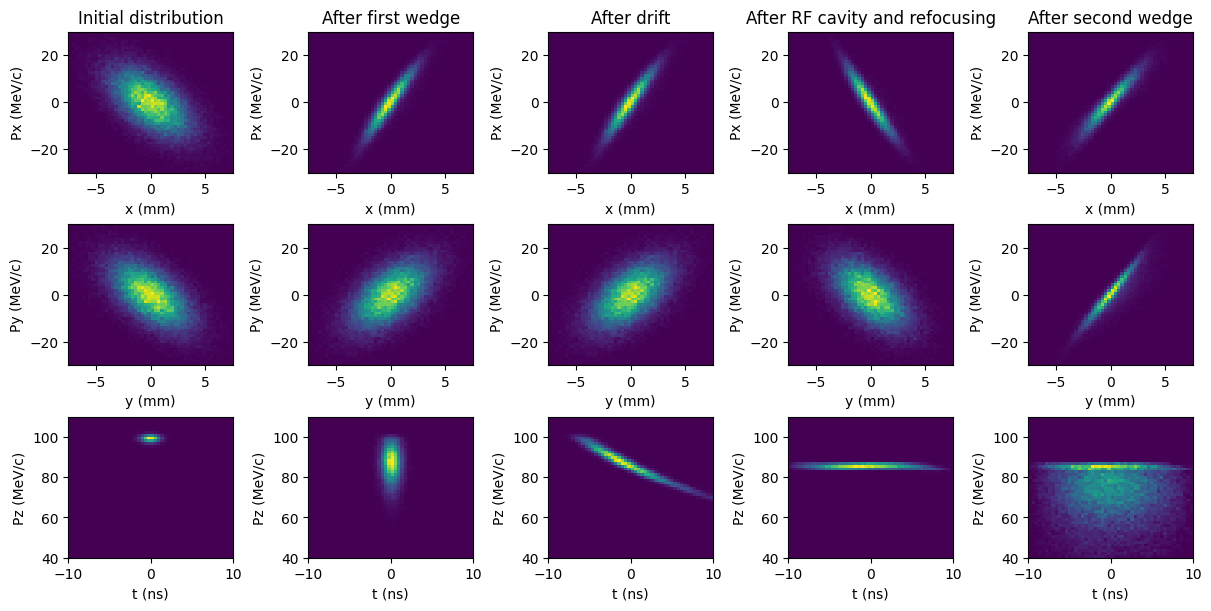

In [ ]:
PLOT_TARGETS = [pre_w1, post_correct, post_drift, pre_w2, remove_dispersion(post_w2_cut)]
PLOT_TITLES = ["Initial distribution", "After first wedge", "After drift", "After RF cavity and refocusing", "After second wedge"]
PLOT_AXES = [("x", "Px"), ("y", "Py"), ("t", "Pz")]
PLOT_LABELS = [("x (mm)", "Px (MeV/c)"), ("y (mm)", "Py (MeV/c)"), ("t (ns)", "Pz (MeV/c)")]
T_RANGES = [[-7.5, 7.5], [-30, 30]]
L_RANGES = [[-10, 10], [40, 110]]

fig, axes = plt.subplots(nrows = len(PLOT_AXES), ncols = len(PLOT_TARGETS), layout="constrained")
fig.set_size_inches(12, 6)
for i, df in enumerate(PLOT_TARGETS):
    axes[0][i].set_title(PLOT_TITLES[i])
    for j, ((xaxis, yaxis), (xlabel, ylabel)) in enumerate(zip(PLOT_AXES, PLOT_LABELS)):
        ax = axes[j][i]
        ax.hist2d(df[xaxis], df[yaxis], bins=50, range=L_RANGES if j == 2 else T_RANGES)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

In [ ]:
SAMPLE_DISTS = [pre_w1, post_correct, pre_w2, post_w2, post_w2_cut]
SAMPLE_TITLES = ["Initial distribution", "After first wedge", "After RF cavity + 15% cut", "After second wedge", "After 4 sigma cut"]
VARIABLE_NAMES = ["x emit (μm)", "y emit (μm)", "z-emit (mm)", "sigma-p (MeV/c)", "sigma-t (ns)", "Beam momentum (MeV/c)", "Beam remaining"]
VARIABLE_FUNCS = [
    lambda df: emittances(df)[0]*1000,
    lambda df: emittances(df)[1]*1000,
    lambda df: emittances(df)[2],
    lambda df: np.std(p_total(df)),
    lambda df: np.std(df["t"]),
    lambda df: np.mean(p_total(df)),
    lambda df: len(df) / len(pre_w1)
]
table = [[n] + [y(x) for y in VARIABLE_FUNCS] for n, x in zip(SAMPLE_TITLES, SAMPLE_DISTS)]
print(tabulate(
    table,
    headers=["Stage"] + VARIABLE_NAMES,
    # tablefmt="latex_raw",
    floatfmt=(None, ".1f", ".1f", ".3f", ".3f", ".3f", ".1f", ".1%")
))
print()
print(tabulate(
    table,
    tablefmt="latex_raw",
    floatfmt=(None, ".1f", ".1f", ".3f", ".3f", ".3f", ".1f", ".1%")
))

Stage                        x emit (μm)    y emit (μm)    z-emit (mm)    sigma-p (MeV/c)    sigma-t (ns)    Beam momentum (MeV/c)    Beam remaining
-------------------------  -------------  -------------  -------------  -----------------  --------------  -----------------------  ----------------
Initial distribution               145.4          145.3          1.254              1.001           0.746                    100.0            100.0%
After first wedge                   45.0          151.7          6.439              7.315           0.746                     87.2            100.0%
After RF cavity + 15% cut           37.3          139.6          4.453              1.308           4.068                     86.4             84.0%
After second wedge                  46.3           61.2         46.429             12.808           4.058                     71.7             80.8%
After 4 sigma cut                   42.9           56.3         45.593             12.582           4.056 

In [ ]:
angles = np.linspace(30, 60, 20)
lengths = np.linspace(5, 11, 20)


In [ ]:
def fun(length, angle):
    return run_distribution(pre_w2, length, angle, 24, axis=1)

results = run_scan(fun, (lengths, angles), filename="results/second_wedge_length_angle.pkl")

100%|██████████| 400/400 [2:08:36<00:00, 19.29s/it]  


In [ ]:
def fun(length, angle):
    return run_distribution(pre_w1, length, angle, 24, axis=0)

results = run_scan(fun, (lengths, angles), filename="results/first_wedge_length_angle.pkl")

100%|██████████| 400/400 [4:22:18<00:00, 39.35s/it]    


Text(-30, 10, '5.99 mm, 56.83 deg')

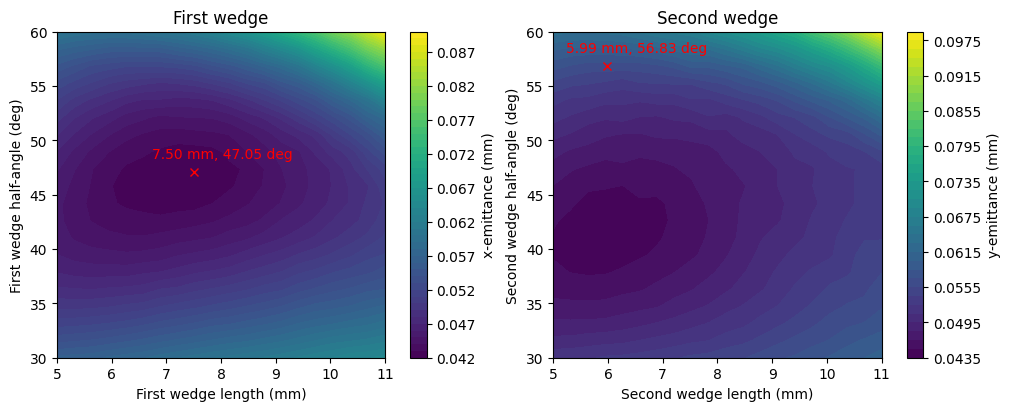

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, layout="constrained")
fig.set_size_inches(10, 4)

# First wedge

with open("results/first_wedge_length_angle.pkl", "rb") as file:
    results = pickle.load(file)

mesh = np.meshgrid(lengths, angles)
meshz = qmap_to_meshgrid(mesh, calc_quantity(lambda df: emittances(cut_outliers(df))[0], results))
meshx, meshy = mesh

cax = ax1.contourf(meshx, meshy, meshz, levels=50)
ax1.set_xlabel("First wedge length (mm)")
ax1.set_ylabel("First wedge half-angle (deg)")
ax1.set_title("First wedge")
plt.colorbar(cax, ax=ax1).set_label("x-emittance (mm)")

ax1.plot(w1_length, w1_angle, 'rx')
ax1.annotate(f"{w1_length:.2f} mm, {w1_angle:.2f} deg", (w1_length, w1_angle), c="red", xytext = (-30, 10), textcoords="offset points")

# Second wedge

with open("results/second_wedge_length_angle.pkl", "rb") as file:
    results = pickle.load(file)

mesh = np.meshgrid(lengths, angles)
meshz = qmap_to_meshgrid(mesh, calc_quantity(lambda df: emittances(cut_outliers(df))[1], results))
meshx, meshy = mesh

cax = ax2.contourf(meshx, meshy, meshz, levels=50)
ax2.set_xlabel("Second wedge length (mm)")
ax2.set_ylabel("Second wedge half-angle (deg)")
ax2.set_title("Second wedge")
plt.colorbar(cax, ax=ax2).set_label("y-emittance (mm)")

ax2.plot(w2_length, w2_angle, 'rx')
ax2.annotate(f"{w2_length:.2f} mm, {w2_angle:.2f} deg", (w2_length, w2_angle), c="red", xytext = (-30, 10), textcoords="offset points")

In [ ]:
rf_freqs = np.linspace(0.01, 0.03, 15)
rf_grads = np.linspace(1,8,15)